In [18]:
from sklearn.model_selection import train_test_split
import torch
import sys
import os
from model import RNNTrainer,RNN_quantum
import numpy as np

import matplotlib.pyplot as plt
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
window_size=10
num_features=9
downsample_step=50 # 0.003 * downsample_step = шаг данных в секундах
target_window_size = 1 # output size количество выходных данных для 1 примера
# Подготовка данных
X, y, df = PD.many_to_many(
    window_size=window_size,
    num_features=num_features,
    downsample_step=downsample_step,
    target_window_size=target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([14407, 10, 9]),
 torch.Size([7097, 10, 9]),
 torch.Size([14407, 1]),
 torch.Size([7097, 1]))

In [3]:
model = RNN_quantum( 
    input_size = X_train.shape[2],
    output_size = 1,
    hidden_size = 32,
    output_sw = target_window_size,
    num_layers = 1,
    device = device)

trainer = RNNTrainer(
    model=model,
    learning_rate=0.001,
    device= device
)


In [4]:
#возможность загрузитиь параметры в модель
# model.load_state_dict(torch.load('up_tree_weight.pth'))
# model = model.to(device)
#возможность сохранить параметры модели
#torch.save(model.state_dict(), 'Quantum_weight3.pth')

In [5]:

history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=64,
    epochs=200,
    loss_tube=5
)

Epoch 1
Train - Total: 3.709119, Main: 1.969643, MAPE: 0.740836, Alpha: 0.865715
Test - MAPE: 0.458758, Tube: 0.079611
Epoch 2
Train - Total: 1.626846, Main: 0.945129, MAPE: 0.516194, Alpha: 0.719830
Test - MAPE: 0.514327, Tube: 0.075948
Epoch 3
Train - Total: 1.626765, Main: 0.945026, MAPE: 0.525721, Alpha: 0.719774
Test - MAPE: 0.507047, Tube: 0.073693
Epoch 4
Train - Total: 1.624015, Main: 0.943659, MAPE: 0.525801, Alpha: 0.719540
Test - MAPE: 0.504542, Tube: 0.075807
Epoch 5
Train - Total: 1.622406, Main: 0.942776, MAPE: 0.527594, Alpha: 0.719341
Test - MAPE: 0.521007, Tube: 0.076088
Epoch 6
Train - Total: 1.623122, Main: 0.943167, MAPE: 0.526468, Alpha: 0.719422
Test - MAPE: 0.515595, Tube: 0.077075
Epoch 7
Train - Total: 1.619932, Main: 0.941303, MAPE: 0.526414, Alpha: 0.718971
Test - MAPE: 0.509513, Tube: 0.073975
Epoch 8
Train - Total: 1.624702, Main: 0.944007, MAPE: 0.526522, Alpha: 0.719601
Test - MAPE: 0.522165, Tube: 0.074820
Epoch 9
Train - Total: 1.622781, Main: 0.942948,

In [6]:
LV = LossVisualizer(history)

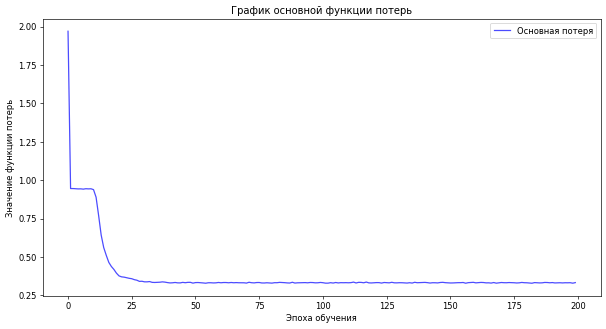

In [7]:
LV.show_training_loss()

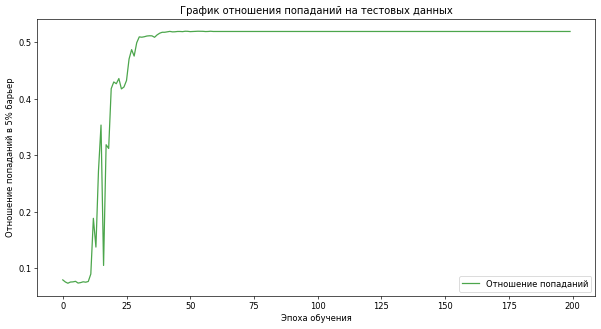

In [9]:
LV.show_test_tube()

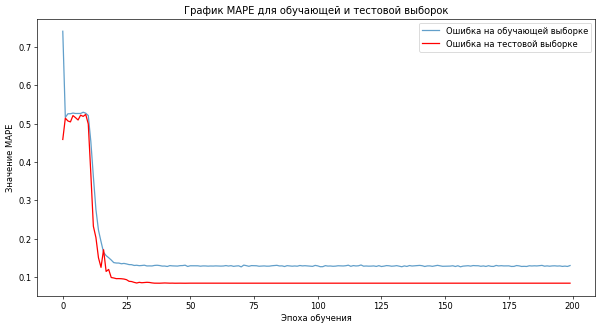

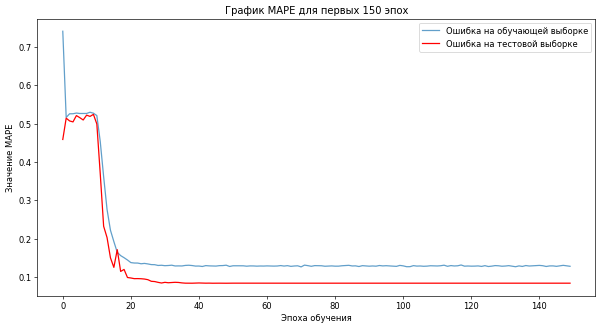

In [17]:
LV.show_mape()

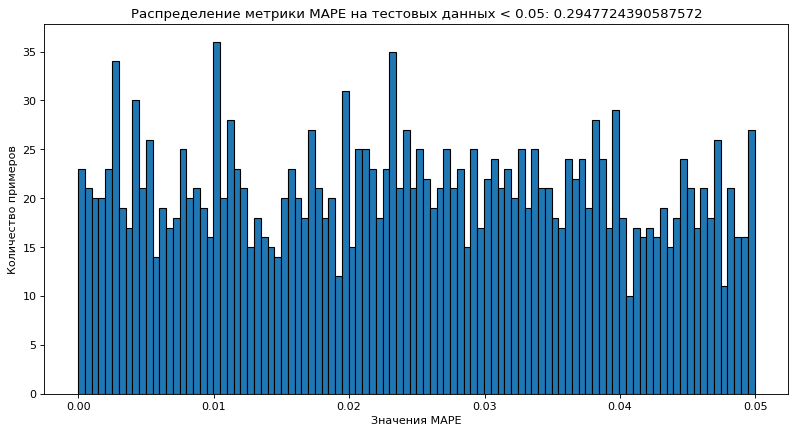

Процент значений MAPE < 0.05: 29.48%


In [16]:
LV.histogram_mape(model,X_test,y_test,limit_percel = 5)

Количество записей: 5334


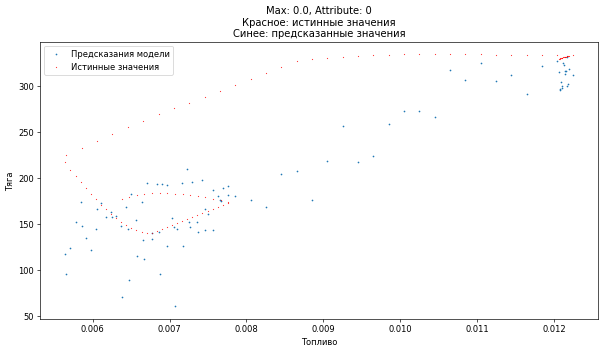

Количество записей: 5334


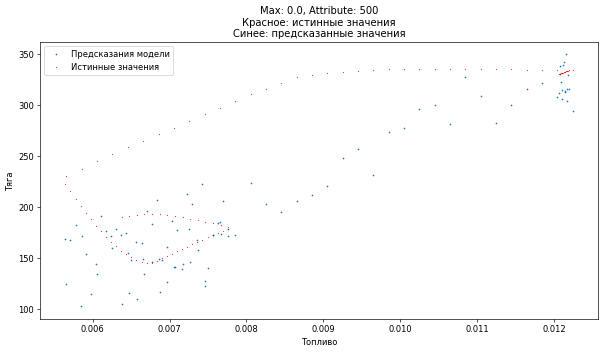

Количество записей: 5334


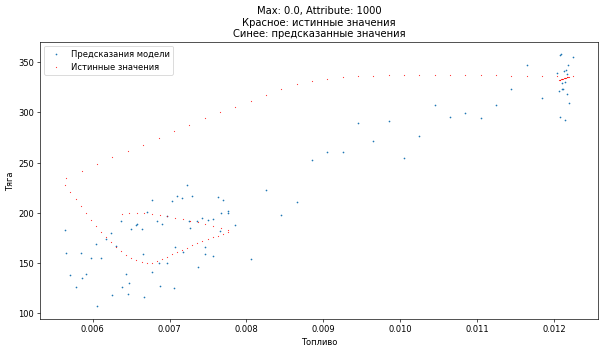

Количество записей: 5334


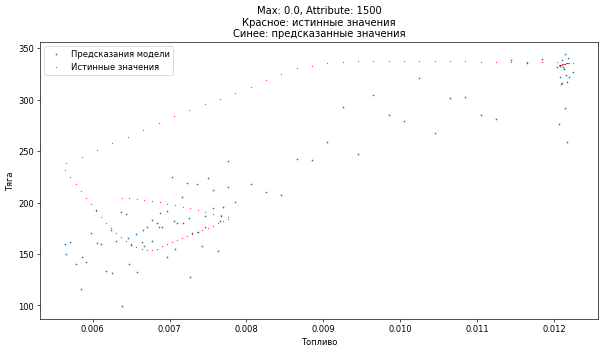

Количество записей: 5334


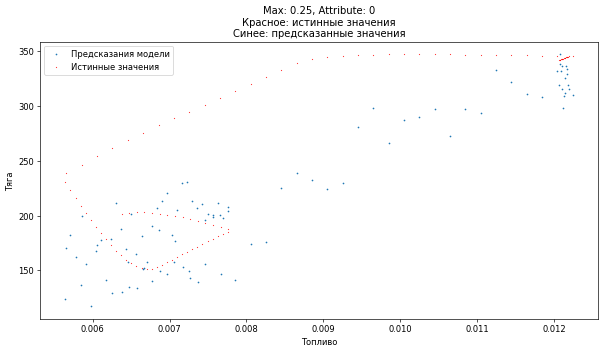

Количество записей: 5334


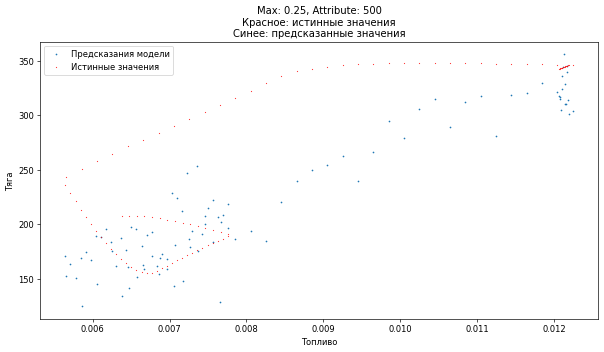

Количество записей: 5334


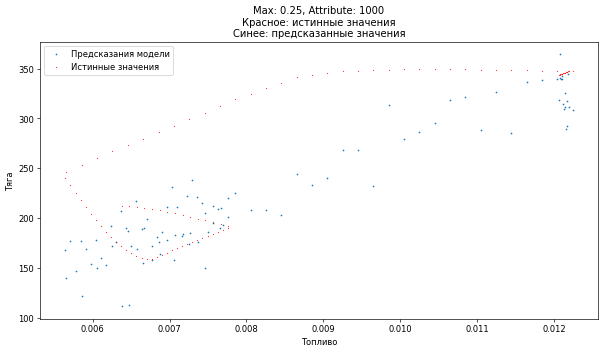

Количество записей: 5334


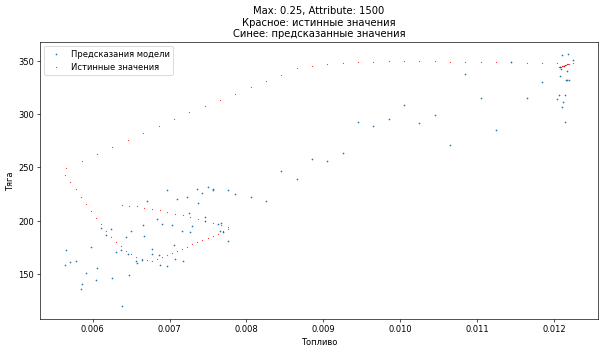

Количество записей: 5334


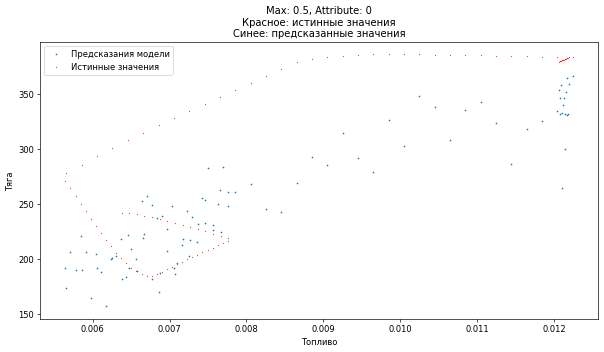

Количество записей: 5334


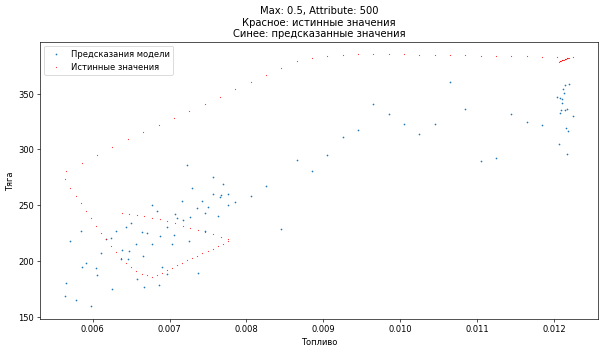

Количество записей: 5334


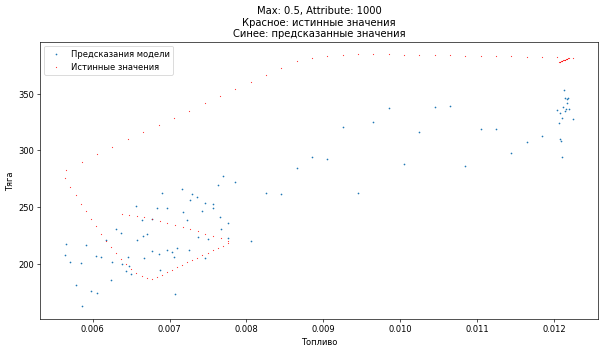

Количество записей: 5334


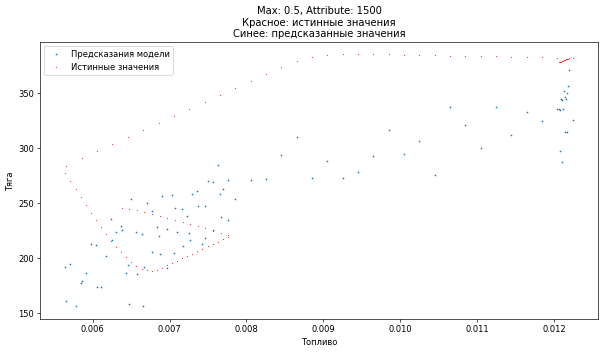

Количество записей: 5334


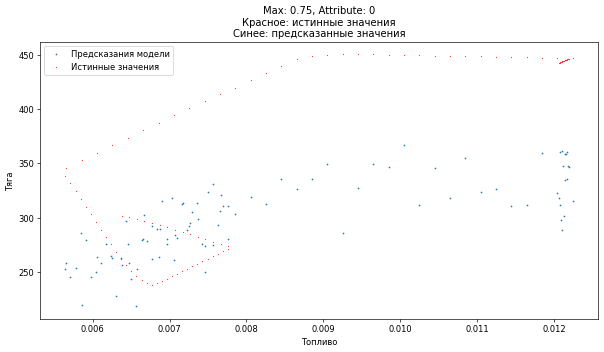

Количество записей: 5334


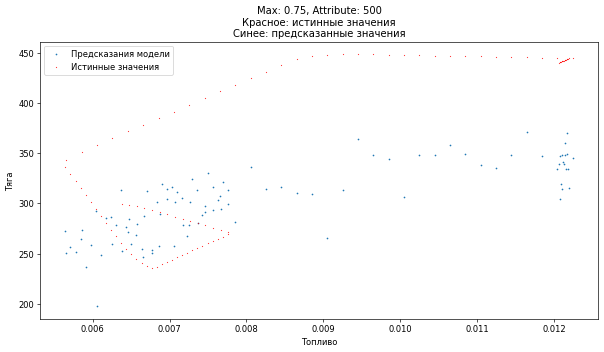

Количество записей: 5334


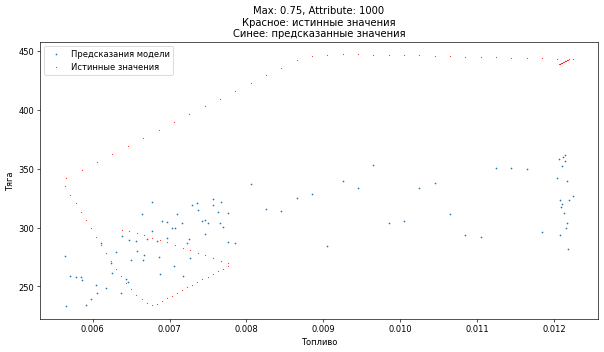

Количество записей: 5334


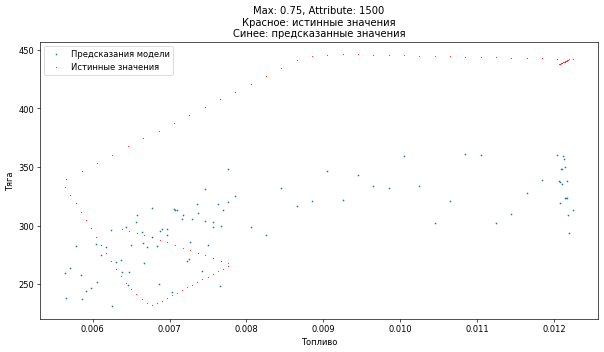

Количество записей: 5334


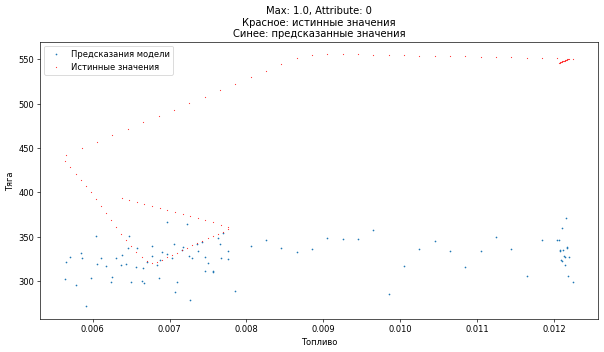

Количество записей: 5334


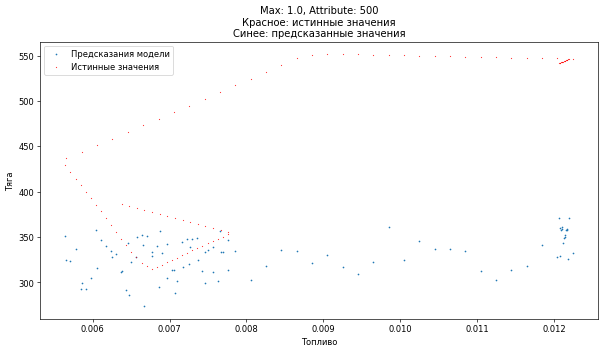

Количество записей: 5334


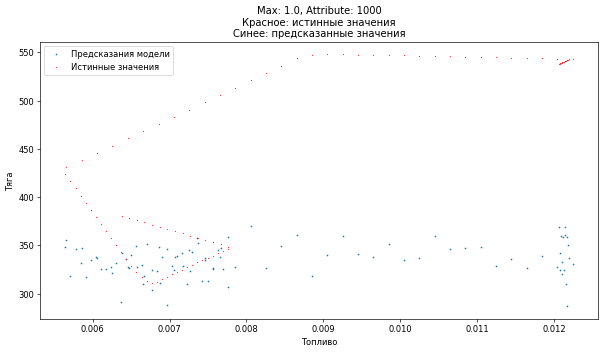

Количество записей: 5334


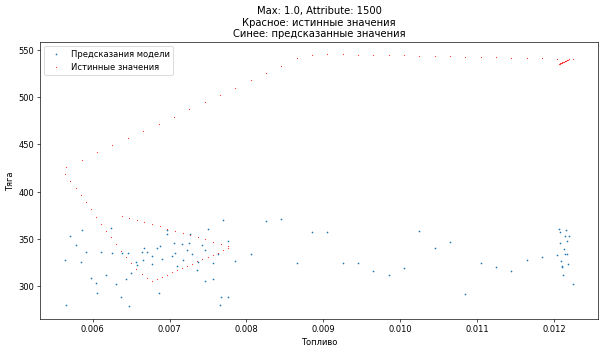

In [12]:
LV.show_predictions_rnn(model,df,device)

ЗДЕСЬ БУДЕТ ПРЕДСКАЗАНИЕ ЕСЛИ ЗАДАН ТОЛЬКО ПЕРВЫЙ МОМЕНТ ВРЕМЕНИ, ОСТАЛЬНЫЕ ТЯГИ САМОЛЕТА ПЕРЕДАЮТСЯ ИЗ ПРЕДСКАЗАНИЯ МОДЕЛИ

In [24]:
def req_step(model,df,input_x): 
    #print('input_x',input_x.shape)  
    predict = model(input_x).to(device)
    #print(predict.shape)
    prev = input_x[:,9:]
    #print(prev.shape)
    new_data = df
    #print(new_data.shape)

    cur = torch.cat((prev,predict,new_data),1)
    #print(cur.shape)
    return cur,predict

In [13]:
# можно выбрать attitute и махи
ma = 0.5
att = 500
new_df_for = df[(df[2] == att) & (df[5] == ma)][::50]

cur = torch.zeros((1, 10 * 9 - 1)).to(device)
#print(new_df_for.iloc[:9,1:])
# print(cur[:,:-8 ].shape)
# print(new_df_for.iloc[9][1:9].values.reshape(1,-1).shape)
# print(cur[:,-8: ].shape)
initt = torch.tensor(new_df_for.iloc[0,1:9].values, dtype=torch.float32).reshape(1,-1)
#print(new_inp.shape,initt.shape)
#cur[:,-8: ]= torch.tensor(new_df_for.iloc[0][1:9].values, dtype=torch.float32)
cur[:,:-8 ]= torch.tensor(new_df_for.iloc[:9,1:].values.reshape(1,-1), dtype=torch.float32)
cur[:,-8: ]= torch.tensor(new_df_for.iloc[9,1:9].values.reshape(1,-1), dtype=torch.float32)

data_predict = torch.empty(0).to(device)

In [14]:


for i in range(1, new_df_for.shape[0]):
    new_inp = torch.tensor(new_df_for.iloc[i][1:9].values, dtype=torch.float32).reshape(1,-1).to(device)
    cur, predict = req_step(model, new_inp, cur)
    data_predict = torch.cat((data_predict, predict))

IndexError: too many indices for tensor of dimension 2

In [90]:
data_predict.shape,new_df_for.shape

(torch.Size([106, 1]), (107, 10))

In [91]:
df_for_plot = new_df_for.copy()
placeholder = torch.tensor([[new_df_for.iloc[0, -1]]]) 

data_predict = data_predict.reshape(-1)

print(data_predict.shape) 


torch.Size([106])


In [92]:
x_rt = df_for_plot[1:][1]
y_rt = data_predict.to('cpu').detach().numpy()

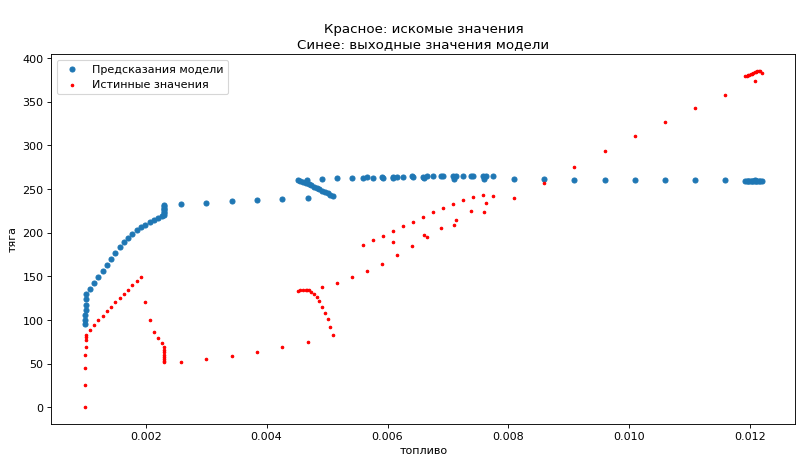

In [93]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x_rt, y_rt, s=20, label='Предсказания модели') 
plt.scatter(new_df_for[1], new_df_for[9], color='r', s=5, label='Истинные значения') 
plt.xlabel('топливо')  
plt.ylabel('тяга')  
plt.title(f'\nКрасное: искомые значения\nСинее: выходные значения модели')  
plt.legend()  
plt.show()